# Distribution of the lengths of the proteins

## [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)
It is a continuous probability distribution of a random variable whose logarithm is normally distributed. For human-readability the decimal logarithm (log10) is used.
  
**The PDF (Probability Density Function) of a normal distribution is**  
$ f(x) = \frac{1}{ \sigma \sqrt{2 \pi}} e^- \frac{1}{2} {(\frac{(x-\mu)}{\sigma})}^{2} $

## Import python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

## The protein length distributions for the different species

### Retrieving the statistical descriptions of the length's distributions

In [2]:
# statistics on length distribution for different species     
stat_file = "../main_tables/stat_proteins.tsv"
print("The statistical descriptions of the protein distributions for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["superregnum", "species", "proteome_id", "tax_id", "uniprot_fasta_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)
    print(stat_df["superregnum"].value_counts())

The statistical descriptions of the protein distributions for the different species is in:
 ../main_tables/stat_proteins.tsv 



,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
0,bacteria,Kurthia sp. 3B1D,UP000288623,1562256,/ftp.uniprot.org/pub/databases/uniprot/current...,3621.0,285.936205,36171.895653,2.372531,0.075378
1,bacteria,Methyloprofundus sedimenti,UP000191980,1420851,/ftp.uniprot.org/pub/databases/uniprot/current...,3608.0,310.654933,52309.438700,2.393412,0.087226


(9915, 10)
bacteria     7997
eukaryota    1588
archaea       330
Name: superregnum, dtype: int64


## Python functions

In [3]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [4]:
#### Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black') # plot 60 bins

    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim([0,2.0])
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [5]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(statistics={k2}, p-value={p_value})")
    #
    # Mathematicaly it ends up beeing a theoretical log-normal when.
    #    - Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
    #    - D'Agostino's K-squared test: p-value $ \leq 0.05 $, becuase it rejects the null hypothesis 

In [6]:
# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_plot_and_fit(stat_df, tax_id):
    species_df = get_df_for_taxid(stat_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    lengths_f = our_mnt_dir + "results/geneLength/" + species_df["uniprot_fasta_file"].item() 
    lengths_f = lengths_f.replace(".fasta.gz", ".length.tsv") # I get the 
    print(lengths_f)
    
    # retrieve data
    lens_df = pd.read_csv(lengths_f, sep="\t")
    lens_df = lens_df[["length"]]
    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(lens_df.head(2))
        print(lens_df.shape)
    
    # plot the distributions: observed and theoretical
    lens_df["log10_length"] = lens_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Proteins";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    plot_log_norm (lens_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), int(species_df["count"].item()), 
                   title, subtitle, xlabel, ylabel)  
    # fit to normal
    does_it_fits_normal(lens_df["log10_length"])

## Distributions for different species:

### _Homo sapiens_ (tax_id = 9606)

#### Retrieve its statistical description

In [7]:
tax_id = 9606
human_df = get_df_for_taxid(stat_df, tax_id)
display(human_df)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
9003,eukaryota,Homo sapiens (Human),UP000005640,9606,/ftp.uniprot.org/pub/databases/uniprot/current...,20614.0,552.845105,354913.157154,2.601146,0.125239


#### Retrieve its genes

In [8]:
# system dependencies
system = list(os.uname())[0]
if system == 'Linux':
    our_mnt_dir = "/media/emuro/Nubya/" # my disks: Nubya, Wes
elif system == 'Darwin':
    our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 

prots_f = our_mnt_dir + "results/geneLength/" + human_df["uniprot_fasta_file"].item() 
prots_f = prots_f.replace(".fasta.gz", ".length.tsv") # I get the 
print("All the proteins with their lengths of the species are in:\n", prots_f, "\n")

# retrieve data
prots_df = pd.read_csv(prots_f, sep="\t")
prots_df = prots_df[["length"]]  


# visualize data
pd.set_option('display.max_columns', None)
if 0:
    display(prots_df.head(2))
    print(prots_df.shape)

All the proteins with their lengths of the species are in:
 /Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.length.tsv 



#### Plot the $log_{10}(length)$ distribution and the fit to a theoretical log10-normal

µ: 2.6011463573824893 	σ: 0.3538905693139241


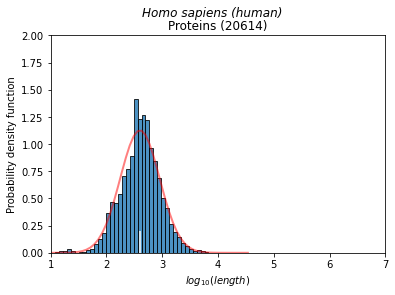

In [9]:
prots_df["log10_length"] = prots_df["length"].apply(np.log10)
title = human_df["species"].item().capitalize(); subtitle = "Proteins";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
plot_log_norm (prots_df["log10_length"], human_df["log10_mean"].item(), math.sqrt(human_df["log10_var"].item()), int(human_df["count"].item()), 
               title, subtitle, xlabel, ylabel)  

#### Does the distribution fits the normal distribution?

In [10]:
does_it_fits_normal(prots_df["log10_length"]) 

Kurtosis: 1.163832716732534
Skewness: -0.26039124808735764
D'Agostino's K-squared test(statistics=717.1684257602484, p-value=1.8571844920422435e-156)


### _Danio rerio_ (tax_id = 7955)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
7681,eukaryota,Danio rerio (Zebrafish) (Brachydanio rerio),UP000000437,7955,/ftp.uniprot.org/pub/databases/uniprot/current...,25706.0,538.158329,315453.463435,2.599115,0.114029


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000437/UP000000437_7955.length.tsv
µ: 2.599115440779346 	σ: 0.3376817874330292


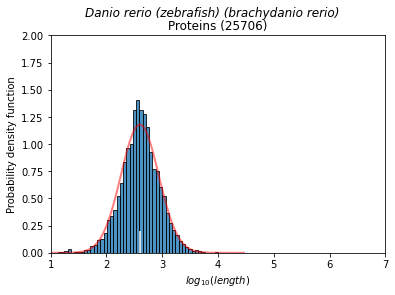

Kurtosis: 0.8752018347236281
Skewness: -0.138739152539118
D'Agostino's K-squared test(statistics=494.0354527107476, p-value=5.267014471006957e-108)


In [11]:
tax_id = 7955
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Drosophila melanogaster_ (tax_id = 7227)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
3635,eukaryota,Drosophila melanogaster (Fruit fly),UP000000803,7227,/ftp.uniprot.org/pub/databases/uniprot/current...,13821.0,535.649085,376540.881915,2.577192,0.131373


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000803/UP000000803_7227.length.tsv
µ: 2.5771919612400653 	σ: 0.3624537280491678


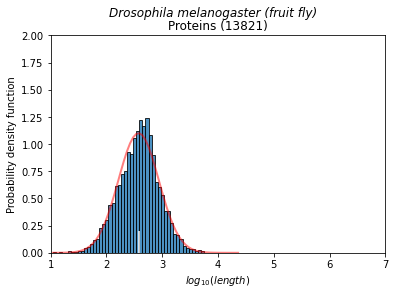

Kurtosis: 0.3248347849271651
Skewness: -0.08267683943107461
D'Agostino's K-squared test(statistics=61.497348374203234, p-value=4.4260923856861545e-14)


In [12]:
tax_id = 7227
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Arabidopsis thaliana_ (tax_id = 3702)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
4739,eukaryota,Arabidopsis thaliana (Mouse-ear cress),UP000006548,3702,/ftp.uniprot.org/pub/databases/uniprot/current...,27468.0,404.901267,90791.833554,2.499364,0.103077


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000006548/UP000006548_3702.length.tsv
µ: 2.499363643151627 	σ: 0.3210561738747564


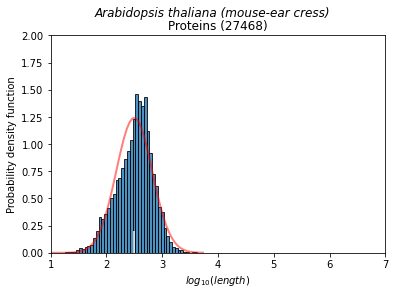

Kurtosis: 0.243976066210577
Skewness: -0.4255467328648886
D'Agostino's K-squared test(statistics=818.4263474448735, p-value=1.9097509301707898e-178)


In [13]:
tax_id = 3702
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Saccharomyces cerevisae_ (tax_id = 4932)

In [27]:
#tax_id = 4932 #uniprot: 559292 (not in ensembl) 
#species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Escherichia coli_ (tax_id = 83333)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
6920,bacteria,Escherichia coli O157:H7,UP000000558,83334,/ftp.uniprot.org/pub/databases/uniprot/current...,5062.0,308.446859,57190.175698,2.38364,0.096586


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000558/UP000000558_83334.length.tsv
µ: 2.383639936200562 	σ: 0.3107836062504229


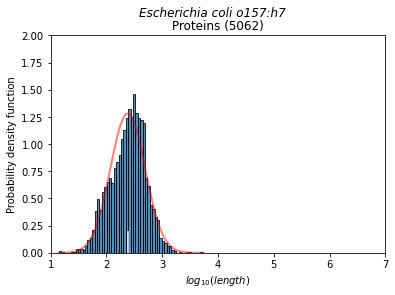

Kurtosis: -0.010812589593092614
Skewness: -0.23530626497822155
D'Agostino's K-squared test(statistics=45.62522286350305, p-value=1.237681038117231e-10)


In [15]:
tax_id = 83334 #562 uniprot: 83333 (k12), 83334(0157:h7 disease), 1408285 (otra, this is not in ensembl)
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

## Fig. 1

### _Danio rerio_ (tax_id = 7955)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
7681,eukaryota,Danio rerio (Zebrafish) (Brachydanio rerio),UP000000437,7955,/ftp.uniprot.org/pub/databases/uniprot/current...,25706.0,538.158329,315453.463435,2.599115,0.114029


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000437/UP000000437_7955.length.tsv
µ: 2.599115440779346 	σ: 0.3376817874330292


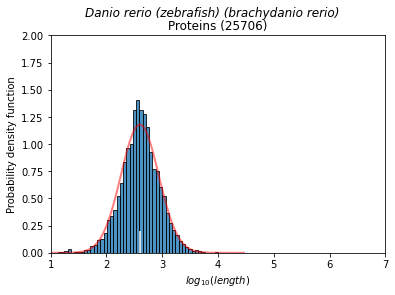

Kurtosis: 0.8752018347236281
Skewness: -0.138739152539118
D'Agostino's K-squared test(statistics=494.0354527107476, p-value=5.267014471006957e-108)


In [16]:
tax_id = 7955
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

## Fig S1

### _Acanthochromis polyacanthus_ (tax_id = 80966)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
6586,eukaryota,Acanthochromis polyacanthus (spiny chromis),UP000257200,80966,/ftp.uniprot.org/pub/databases/uniprot/current...,23617.0,509.734344,208624.909607,2.579212,0.111991


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000257200/UP000257200_80966.length.tsv
µ: 2.5792120754981043 	σ: 0.3346501133150373


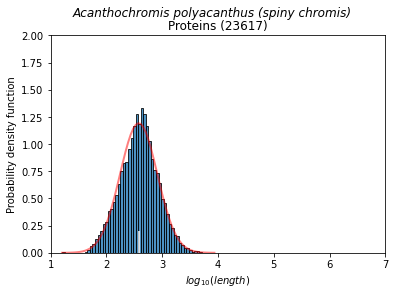

Kurtosis: -0.014615144910329114
Skewness: -0.030519700074858287
D'Agostino's K-squared test(statistics=3.8589563662198394, p-value=0.14522395903000448)


In [17]:
tax_id = 80966
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Apteryx owenii_ (tax_id = 8824)

In [18]:
#tax_id = 8824
#species_distribution__retrieve_plot_and_fit(stat_df, 8824)

### _Equus asinus asinus_ (tax_id = 83772)

In [19]:
#tax_id = 83772
#species_distribution__retrieve_plot_and_fit(stat_df, 83772)

### _Vitis vinifera_ (tax\_id = 29760)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
1960,eukaryota,Vitis vinifera (Grape),UP000009183,29760,/ftp.uniprot.org/pub/databases/uniprot/current...,29874.0,360.439948,95455.162949,2.399108,0.160564


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000009183/UP000009183_29760.length.tsv
µ: 2.3991081574448803 	σ: 0.40070495803076095


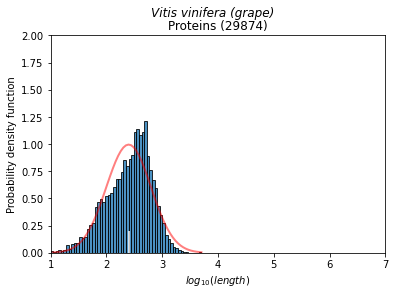

Kurtosis: -0.027310272104067224
Skewness: -0.51150105984262
D'Agostino's K-squared test(statistics=1162.4570857747017, p-value=3.7640128669531653e-253)


In [20]:
tax_id = 29760
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Acinetobacter baumannii_ (tax\_id = 1310800)

In [21]:
#tax_id = 1310800
#species_distribution__retrieve_plot_and_fit(stat_df, 1310800)

### _Colletotrichum gloeosporioides_ (tax\_id = 1213859)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
198,eukaryota,Colletotrichum fructicola (strain Nara gc5) (A...,UP000011096,1213859,/ftp.uniprot.org/pub/databases/uniprot/current...,17182.0,469.889652,129150.736789,2.575889,0.086285


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000011096/UP000011096_1213859.length.tsv
µ: 2.5758893630251287 	σ: 0.2937439099550416


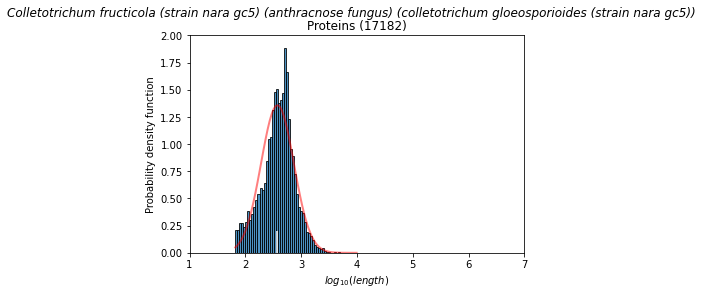

Kurtosis: 0.2077139256197209
Skewness: -0.21180489918702788
D'Agostino's K-squared test(statistics=151.54596784634086, p-value=1.2365486419655705e-33)


In [22]:
tax_id = 1213859
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

## Fig S2

### _Cavia porcellus_ (tax\_id = 10141)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
3647,eukaryota,Cavia porcellus (Guinea pig),UP000005447,10141,/ftp.uniprot.org/pub/databases/uniprot/current...,18247.0,540.943169,246132.162669,2.6082,0.107282


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005447/UP000005447_10141.length.tsv
µ: 2.6081999542155296 	σ: 0.3275391435998644


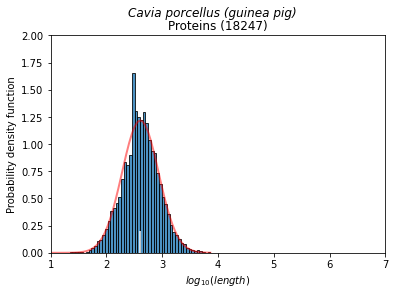

Kurtosis: 0.453719686546751
Skewness: -0.02500681788721736
D'Agostino's K-squared test(statistics=107.87728120235484, p-value=3.7561767965780544e-24)


In [23]:
tax_id = 10141
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

## Fig S7

### _Shewanella loihica_ (tax\_id = 323850)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
4800,bacteria,Shewanella loihica (strain ATCC BAA-1088 / PV-4),UP000001558,323850,/ftp.uniprot.org/pub/databases/uniprot/current...,3855.0,339.778729,60661.644073,2.440595,0.079555


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000001558/UP000001558_323850.length.tsv
µ: 2.4405946049463645 	σ: 0.28205457432966796


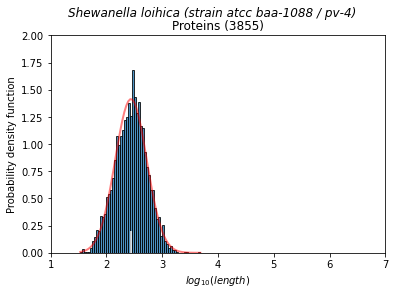

Kurtosis: -0.09329483526783733
Skewness: -0.04857619394836839
D'Agostino's K-squared test(statistics=2.9239278013247283, p-value=0.23178063331967275)


In [24]:
tax_id = 323850
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### _Orchesella cincta_ (tax\_id = 48709)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
634,eukaryota,Orchesella cincta (Springtail),UP000094527,48709,/ftp.uniprot.org/pub/databases/uniprot/current...,20218.0,424.12019,156494.930996,2.495977,0.115681


/Volumes/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000094527/UP000094527_48709.length.tsv
µ: 2.4959771728410467 	σ: 0.3401194732115712


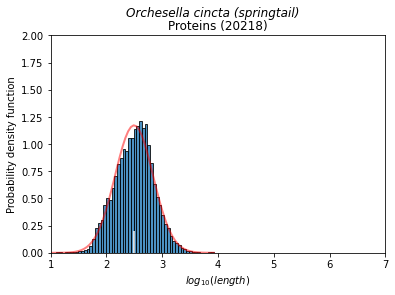

Kurtosis: 0.07804696175054904
Skewness: -0.07578260990627901
D'Agostino's K-squared test(statistics=24.185233843939038, p-value=5.600711459410769e-06)


In [25]:
tax_id = 48709
species_distribution__retrieve_plot_and_fit(stat_df, tax_id)